In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import logging

logger = logging.getLogger(__name__)

os.chdir("../")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.etl import *
from src.rfm import *
from src.utils import *

In [4]:
url = "https://www.gutenberg.org/cache/epub/1533/pg1533-images.html"

make_dataset(url)

Dataset already downloaded: download_log -> 6157ee4b54ae1a9c39fa52c057f5dfbd80554c634644ba4fc805528bf36a68f7


False

In [5]:
X, vocab = tokenizer("./data/Author: William Shakespeare.txt")

In [6]:
X.shape

(853, 32, 64)

In [7]:
data = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

In [8]:
data.shape

(853, 2048)

In [9]:
vocab

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 '.': 53,
 ',': 54,
 '!': 55,
 '?': 56,
 "'": 57,
 ':': 58,
 ';': 59,
 '-': 60,
 '_': 61,
 ' ': 0,
 '[PAD]': 62,
 '[UNK]': 63}

## Baseline: Bigrams/Trigrams

In [120]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [121]:
CONTEXT_SIZE = 32
TEST_SPLIT = 0.2

In [122]:
def clean_sentence(sent):
    # remove newline and separate into characters
    sent = list(sent[:-1])
    # add start token and truncate to context size
    sent = (["<START>"] + sent)[:CONTEXT_SIZE]
    # pad to context size
    if len(sent) == CONTEXT_SIZE:
        return sent
    elif len(sent) < CONTEXT_SIZE:
        # add end token
        sent = sent + ["<END>"]
        return sent + ["<PAD>"] * (CONTEXT_SIZE - len(sent))
    else:
        raise ValueError("Sentence too long after truncating. Something went wrong.")


In [123]:
# get the text

fpath = "./data/Author: William Shakespeare.txt"
raw = open(fpath, "r").readlines()
sentences = list(map(clean_sentence, raw))
train_sentences = sentences[:int(len(sentences) * (1 - TEST_SPLIT))]
test_sentences = sentences[int(len(sentences) * (1 - TEST_SPLIT)):]
len(train_sentences)

682

In [124]:
np.array(train_sentences)[:, :16].shape

(682, 16)

In [125]:
# shop the dataset in half. The first half will be used to condition the second half
CONTEXT_SPLIT_SIZE = 24
X_train = np.array(train_sentences)[:, :CONTEXT_SPLIT_SIZE]
y_train = np.array(train_sentences)[:, CONTEXT_SPLIT_SIZE:]
X_test = np.array(test_sentences)[:, :CONTEXT_SPLIT_SIZE]
y_test = np.array(test_sentences)[:, CONTEXT_SPLIT_SIZE:]

In [126]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))


In [127]:
# pad the text
vocab = list(flatten(sent for sent in X_train))

In [128]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [129]:
X_train[1]

array(['<START>', 'A', 'u', 't', 'h', 'o', 'r', ':', ' ', 'W', 'i', 'l',
       'l', 'i', 'a', 'm', ' ', 'S', 'h', 'a', 'k', 'e', 's', 'p'],
      dtype='<U7')

In [130]:
def generate_text(lm, X_test, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [131]:
y_test.shape

(171, 8)

In [132]:
y_test_pred = np.array(generate_text(lm, X_test))

In [133]:
"".join(y_test[0]), "".join(y_test_pred[0])

('tstone o', ' r rve d')

In [134]:
lm.vocab.unk_label

'<UNK>'

In [135]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [136]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, ',': 2, '-': 3, '.': 4, ':': 5, ';': 6, '<END>': 7, '<PAD>': 8, '<START>': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, '[': 35, ']': 36, 'a': 37, 'b': 38, 'c': 39, 'd': 40, 'e': 41, 'f': 42, 'g': 43, 'h': 44, 'i': 45, 'j': 46, 'k': 47, 'l': 48, 'm': 49, 'n': 50, 'o': 51, 'p': 52, 'q': 53, 'r': 54, 's': 55, 't': 56, 'u': 57, 'v': 58, 'w': 59, 'x': 60, 'y': 61, 'z': 62, '—': 63, '’': 64, '“': 65, '<UNK>': 66})

In [137]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    y_perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=2))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
        y_perplexity.append(utils.perplexity(encode(y_test[i])))
    return { "bleu2": np.mean(bleu), "perplexity": np.mean(perplexity), "true_perplexity": np.mean(y_perplexity) }

In [138]:
list(map(lambda x: "".join(x), y_test_pred))

[' r rve d',
 ' t.Wit a',
 'my, y it',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'gathengr',
 'e.ACBERD',
 'ACBETHea',
 'l omall ',
 'tearse c',
 't.Thernq',
 'otend LM',
 'il deman',
 ' MANQUO.',
 'f I’stha',
 'omeundit',
 'ttiscbea',
 'rerdssss',
 'FIR.AD i',
 'odonodat',
 'pandandA',
 ' he Mave',
 'r is has',
 'hisethan',
 'myowodo,',
 'de MACHo',
 'd thaite',
 'r cbe k ',
 ' ha wish',
 'os ascot',
 'ed bif p',
 'h at Maj',
 'ghand d ',
 'ild y nt',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'ullit d!',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'MACDENON',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 ' anornok',
 ' buorH.T',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'f.H.TH. ',
 'u MACBER',
 '.Whahy e',
 'ather be',
 ' d alont',
 'BEThe my',
 'vel, cbl',
 'of.Bury ',
 'vaseyo h',
 'ient ne ',
 ' ie hatl',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'rere ate',
 '.IRD.H.B',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'n

In [139]:
evaluate(y_test, y_test_pred)

/home/arunavgupta/anaconda3/envs/huggingface/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'bleu2': 0.24448386987263054,
 'perplexity': 6.708915373444384,
 'true_perplexity': 6.546585439758883}

## Laplacian Kernel

In [140]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [141]:
# one hot encode the data
X_train_enc = np.eye(len(train_vocab))[X_train_enc]
X_train_enc = X_train_enc.reshape(X_train_enc.shape[0], X_train_enc.shape[1]*X_train_enc.shape[2])
y_train_enc = np.eye(len(train_vocab))[y_train_enc]
y_train_enc = y_train_enc.reshape(y_train_enc.shape[0], y_train_enc.shape[1]*y_train_enc.shape[2])
X_test_enc = np.eye(len(train_vocab))[X_test_enc]
X_test_enc = X_test_enc.reshape(X_test_enc.shape[0], X_test_enc.shape[1]*X_test_enc.shape[2])
y_test_enc = np.eye(len(train_vocab))[y_test_enc]
y_test_enc = y_test_enc.reshape(y_test_enc.shape[0], y_test_enc.shape[1]*y_test_enc.shape[2])

In [142]:
from functools import partial

In [143]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [144]:
# train a laplace kernel
lam = 1
kernel = partial(utils.K_laplace_mat, gamma=0.025)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [145]:
yhat = kernel(X_test_enc, X_train_enc) @ alpha_hat
yhat

array([[ 0.2646873 ,  0.02268584, -0.01012501, ..., -0.00095572,
         0.        , -0.00440535],
       [-0.05092252, -0.01318122,  0.07413808, ...,  0.01220229,
         0.        , -0.0062672 ],
       [ 0.02476795,  0.03200875, -0.03727128, ...,  0.00805032,
         0.        ,  0.00432252],
       ...,
       [-0.00412403, -0.00120126,  0.02334853, ..., -0.00195932,
         0.        ,  0.00688799],
       [ 0.05646939,  0.0515744 ,  0.00425799, ...,  0.00159293,
         0.        , -0.00581609],
       [ 0.01324782, -0.00396975,  0.02280295, ...,  0.00666102,
         0.        ,  0.00480754]])

In [146]:
(next_char_test.argmax(axis=1) == yhat.argmax(axis=1)).mean()

0.2982456140350877

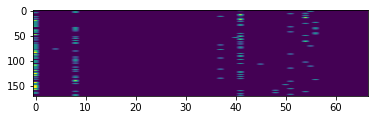

In [147]:
max_index = np.argmax(yhat, axis=1)
yhat[np.arange(yhat.shape[0]), max_index] = 1
yhat[yhat != 1] = 0
plt.imshow(yhat, aspect=0.1)

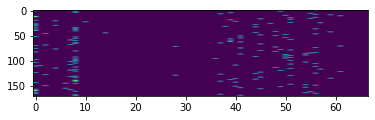

In [148]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_test, aspect=0.1)

In [149]:
yhat_train = kernel(X_train_enc, X_train_enc) @ alpha_hat

(next_char_train.argmax(axis=1) == yhat_train.argmax(axis=1)).mean()

0.9941348973607038

In [150]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([train_vocab.decode(y) for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [151]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [152]:
list(map(lambda x: "".join(x), generated_test))

[' e  oe  ',
 'e    <PAD>  ',
 'so  e   ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '     <PAD> <PAD>',
 're   <PAD> <PAD>',
 'o o e  r',
 'e e   <PAD><PAD>',
 'eoi ee e',
 'r ee    ',
 'e  ee  e',
 'a  o<PAD>de ',
 '    e <PAD> ',
 'r e  e o',
 'r  er e ',
 'e  e    ',
 '  eere o',
 'e  ee   ',
 'e   e  <PAD>',
 ' a  o e ',
 '     <PAD><PAD> ',
 'e    ne<PAD>',
 '   eeee<PAD>',
 'te      ',
 ' e r    ',
 'r   r  e',
 '  e  a  ',
 'ee eh  <PAD>',
 ' e  t<PAD>ee',
 'eo <PAD> <PAD>e<PAD>',
 ' r  e   ',
 ' e e    ',
 'oe  e e ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'te e r <PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'teer <PAD>  ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '  r<PAD> <PAD><PAD> ',
 '    e <PAD> ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 ' r e <PAD><PAD> ',
 'o  e    ',
 '  <PAD><PAD><PAD><PAD>  ',
 'toee e<PAD> ',
 'e e <PAD>  <PAD>',
 'te  e en',
 '   <END> e <PAD>',
 '  n <PAD> <PAD><PAD>',
 '

In [153]:
evaluate(y_test, generated_test)

{'bleu2': 0.21878131848379992,
 'perplexity': 4.0477654772345755,
 'true_perplexity': 6.546585439758883}

## RFM

In [235]:
alpha, M, _ = train_rfm(X_train_enc, next_char_train, L=24)

In [236]:
y_train_pred = utils.K_M(X_train_enc, X_train_enc, M, L=24) @ alpha

In [237]:
utils.mse(y_train_pred, next_char_train)


8.314221792752528e-05

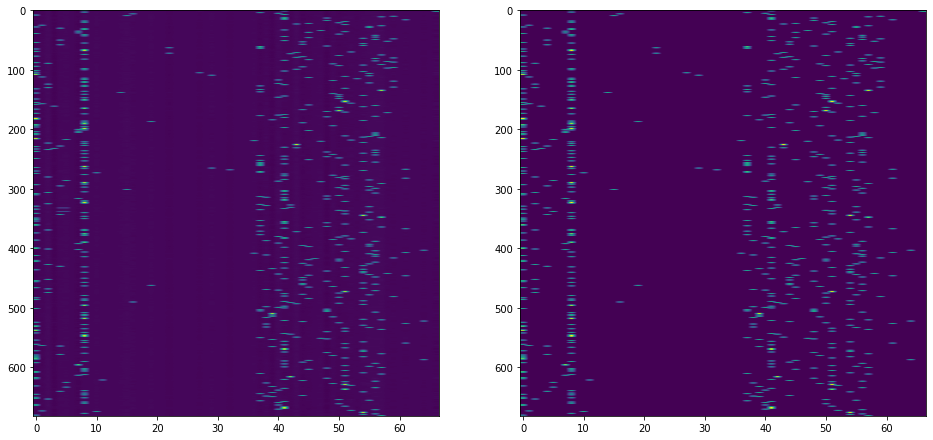

In [238]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_train_pred.shape[1]/y_train_pred.shape[0])
ax[0].imshow(utils.softmax(y_train_pred, axis=1), aspect=ar)
ax[1].imshow(next_char_train, aspect=ar)

In [239]:
y_test_pred = utils.K_M(X_test_enc, X_train_enc, M, L=24) @ alpha

In [240]:
utils.mse(y_test_pred, next_char_test)

0.01405779091654209

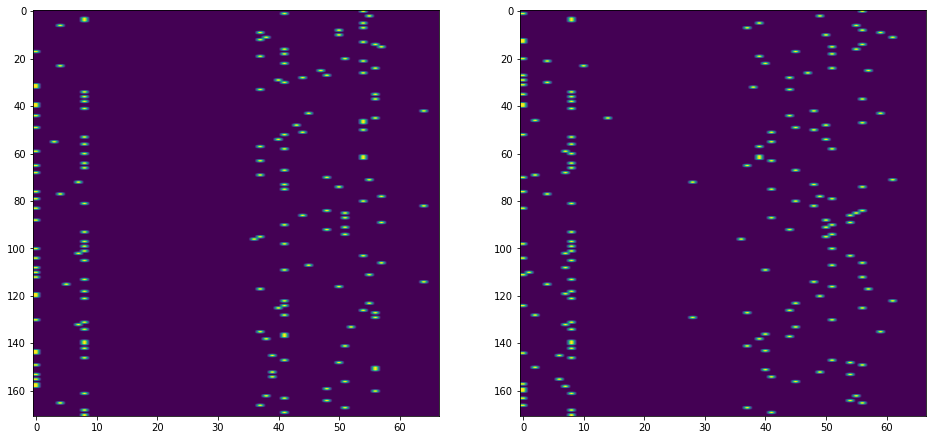

In [241]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_test_pred.shape[1]/y_test_pred.shape[0])
y_test_argmax_ohc = np.eye(len(train_vocab))[y_test_pred.argmax(axis=1)]
ax[0].imshow(y_test_argmax_ohc, aspect=ar)
ax[1].imshow(next_char_test, aspect=ar)

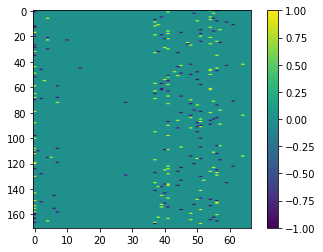

In [242]:
plt.imshow(y_test_argmax_ohc - next_char_test, aspect=ar)
plt.colorbar()

In [243]:
from functools import partial

In [244]:
kernel_rfm = partial(utils.K_M, M=M, L=24)

gen_test_rfm = generate_text_kernel(kernel_rfm, alpha, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [245]:
evaluate(y_test, gen_test_rfm)

{'bleu2': 0.2368750719619246,
 'perplexity': 5.826879811502743,
 'true_perplexity': 6.546585439758883}

In [246]:
list(map(lambda x: "".join(x), gen_test_rfm))

['re go  a',
 'e ,  r  ',
 'shote  h',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'r.  ai ?',
 '.yoru<PAD> a',
 'rym hs r',
 'ny    <PAD>e',
 'ani tr a',
 'n aern r',
 'be!ne sh',
 'a  oode ',
 'rn ye t ',
 'taeane s',
 'ue eh me',
 'e thn to',
 ' derra o',
 'eageu   ',
 'ae  ee t',
 'oa cl e ',
 'r] tt<PAD><PAD><PAD>',
 'e am neo',
 '.l,uy<END>el',
 'th mh uo',
 'kelryo  ',
 'r,  re s',
 'l  moang',
 'he ehv a',
 'de  ts.n',
 'eous to<PAD>',
 ' r  no e',
 ' t aokea',
 'ahi f re',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'tl noa m',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'tars n  ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 ' arra u<PAD>',
 ' b.uo ae',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '’r kha e',
 'ie,e ra ',
 '  ho., o',
 'to , rea',
 'rands  <PAD>',
 'rue e an',
 'gfa<END> it<PAD>',
 ' khnu ne',
 'ralui rn',
 'h re rho',
 'e itvee ',
 '<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'd  oe t ',
 '-ndesorn',
 '<P

In [247]:
# get train and test accuracy
train_acc = (next_char_train.argmax(axis=1) == y_train_pred.argmax(axis=1)).mean()
test_acc = (next_char_test.argmax(axis=1) == y_test_pred.argmax(axis=1)).mean()

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 1.00
Test accuracy: 0.29
